# Setup 

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

# Grid, params, forcing helpers, output dir

In [ ]:
import numpy as np
from pathlib import Path

from src.runner import solve_fixed_step
from src.models.sw_adapter import rhs, sw_cfl, make_initial_sw
from src.utils.forcing import make_forcings, sinusoid_Fh

# grid & numerics
Ny, Nx = 128, 192
Lx, Ly = 1.0, 0.75
dx, dy = Lx / Nx, Ly / Ny
g, f, nu = 9.81, 1e-4, 1e-4

# initial state
Y0 = make_initial_sw(Ny, Nx, h0=1.0, jet_amp=0.06)
h0 = float(Y0[0].mean())
c0 = np.sqrt(g * h0)
dt = 0.25 * min(dx, dy) / c0
T  = 0.5

base_params = {"g": g, "f": f, "nu": nu, "dx": dx, "dy": dy}

out_dir = ROOT / "outputs" / "era5_to_sw_v4"
out_dir.mkdir(parents=True, exist_ok=True)

ImportError: cannot import name 'rhs_sw_2d' from 'src.models.shallow_water' (/Users/linearityproductions/Desktop/pneuma/src/models/shallow_water.py)

# Option A (no data): mock “ERA5-like” run (always works)

In [ ]:
from src.io.reanalysis import mock_height_anomaly

anom = mock_height_anomaly(Ny, Nx, amp=0.03)
Y0_A = Y0.copy()
Y0_A[0] = 1.0 + anom  # h = h0 + anomaly

# start with zero heating (mass conserved); turn on later if you want
FhA = sinusoid_Fh(amplitude=0.0, period=1.0)
FcfgA = make_forcings(Ny, Nx, {"Fh": FhA, "Du": 2e-3, "Dv": 2e-3})
paramsA = {**base_params, **FcfgA}

solA = solve_fixed_step(
    f=rhs, t_span=(0.0, T), y0=Y0_A, dt=dt, method="rk4",
    params=paramsA, save_every=20, metrics_out_dir=out_dir / "mock",
    norm_grid=(dx, dy),
    cfl_specs={"gw": {"type": "advection", "dt": dt, "dx": min(dx,dy),
                      "u": np.abs(Y0_A[1]) + np.sqrt(g * Y0_A[0])}},
)

cfls = [sw_cfl(Y, paramsA, dt) for Y in solA.y]
mean_h = [float(np.mean(Y[0])) for Y in solA.y]
print({"cfl_max": float(np.max(cfls)), "mean_h_drift": float(mean_h[-1]-mean_h[0])})

{'cfl_max': 0.2592772075740802, 'mean_h_drift': 0.0}


# Option B (real NetCDF if present): auto-detect & run

In [ ]:
# ---- Cell D: Option B (real NetCDF if present) — robust subsetting & run ----
DEBUG_REAL = False
try:
    from src.io import reanalysis as rea
    import numpy as np

    DATA_DIR = ROOT / "data"
    nc_files = sorted(DATA_DIR.glob("*.nc"))
    if not nc_files:
        raise FileNotFoundError(f"No .nc in {DATA_DIR}, skipping real-data path.")

    nc_path = nc_files[0]
    print("Using:", nc_path.name)
    ds = rea.open_dataset(str(nc_path))

    # detect coord names
    lon_name = "longitude" if "longitude" in ds.coords else ("lon" if "lon" in ds.coords else None)
    lat_name = "latitude"  if "latitude"  in ds.coords else ("lat" if "lat" in ds.coords else None)
    if lon_name is None or lat_name is None:
        raise ValueError(f"Couldn't find lon/lat coords in {list(ds.coords)}")

    # pick a height-like variable
    var_candidates = ["geopotential", "z", "gh", "height"]
    var = next((v for v in var_candidates if v in ds.data_vars), list(ds.data_vars)[0])
    da = ds[var]
    if "time" in da.dims:
        da = da.isel(time=0)

    # --- robust Cyprus subsetting ---
    lon_vals = ds[lon_name].values
    lat_vals = ds[lat_name].values

    lon0, lon1, lat0, lat1 = 30.0, 36.0, 33.0, 36.5
    use_0360 = (np.nanmax(lon_vals) > 180.0)
    conv = (lambda l: l % 360.0) if use_0360 else (lambda l: l)
    lon0c, lon1c = sorted([conv(lon0), conv(lon1)])
    lat0c, lat1c = sorted([lat0, lat1])

    lon_asc = bool(lon_vals[0] <= lon_vals[-1])
    lat_asc = bool(lat_vals[0] <= lat_vals[-1])

    lon_slice = slice(lon0c, lon1c) if lon_asc else slice(lon1c, lon0c)
    lat_slice = slice(lat0c, lat1c) if lat_asc else slice(lat1c, lat0c)

    print(
        "file lon range:", float(np.nanmin(lon_vals)), "→", float(np.nanmax(lon_vals)),
        "| order:", "asc" if lon_asc else "desc",
        "| file lat range:", float(np.nanmin(lat_vals)), "→", float(np.nanmax(lat_vals)),
        "| order:", "asc" if lat_asc else "desc"
    )

    ds_sub = ds.sel({lon_name: lon_slice, lat_name: lat_slice})

    # if empty, fall back to full domain
    sizes = getattr(ds_sub, "sizes", {})
    if int(sizes.get(lat_name, 0)) == 0 or int(sizes.get(lon_name, 0)) == 0:
        print("WARN: subsetting returned empty; falling back to full domain in file.")
        ds_sub = ds

    # 2D lat/lon field only
    da_sub = ds_sub[var]
    for d in list(da_sub.dims):
        if d not in (lat_name, lon_name):
            da_sub = da_sub.isel({d: 0})
    da_sub = da_sub.squeeze(drop=True).transpose(lat_name, lon_name)

    # rename so interp_to_grid expects 'longitude'/'latitude'
    if lon_name != "longitude" or lat_name != "latitude":
        da_sub = da_sub.rename({lon_name: "longitude", lat_name: "latitude"})

        # --- interpolate to model grid, sanitize raw field ---
    field = rea.interp_to_grid(da_sub, Nx=Nx, Ny=Ny).astype(np.float64)

    # convert geopotential (m²/s²) -> height (m) if applicable
    if var.lower() in {"geopotential", "z", "gh"}:
        field = field / g

    # replace NaN/Inf with mean and clamp the worst outliers
    mean_f = float(np.nanmean(field))
    if not np.isfinite(mean_f):
        raise ValueError("Interpolated field is all-NaN or invalid.")
    field = np.nan_to_num(field, nan=mean_f, posinf=mean_f, neginf=mean_f)
    q01, q99 = np.quantile(field, [0.01, 0.99])
    field = np.clip(field, max(1e-6, q01), max(q99, 1e-6))

    # ---- build a SMALL anomaly around 1.0 (±5%) to keep CFL sane ----
    # normalize → anomaly
    mean_field = float(field.mean())
    anom = field / mean_field - 1.0
    amax = float(np.nanmax(np.abs(anom))) or 1.0
    target = 0.05  # ±5% variation
    scale = min(target / amax, 1.0)
    anom = np.clip(anom * scale, -target, target)

    # optional light smoothing to remove grid noise
    from src.models.sw_balance import box_smooth
    h_ic = 1.0 + box_smooth(anom, iters=1)

    # ---- initial condition: ERA5 height, zero winds ----
    Y0_B = Y0.copy()
    Y0_B[0] = h_ic
    Y0_B[1].fill(0.0)
    Y0_B[2].fill(0.0)

    # ---- conservative dt from LOCAL gravity-wave speed ----
    dx_min = min(dx, dy)
    cmax0 = float(np.nanmax(np.sqrt(g * np.maximum(Y0_B[0], 1e-12))))
    CFL_TGT = 0.15  # tighter than 0.20
    dt_B = CFL_TGT * dx_min / max(cmax0, 1e-12)

    # ---- mild damping; no heating for a clean mass check ----
    FcfgB = make_forcings(Ny, Nx, {"Fh": None, "Du": 3e-3, "Dv": 3e-3})
    paramsB = {**base_params, **FcfgB}

    solB = solve_fixed_step(
        f=rhs, t_span=(0.0, T), y0=Y0_B, dt=dt_B, method="rk4",
        params=paramsB, save_every=20, metrics_out_dir=out_dir / "real_nc",
        norm_grid=(dx, dy),
        cfl_specs={"gw": {"type": "advection", "dt": dt_B, "dx": dx_min,
                          "u": np.abs(Y0_B[1]) + np.sqrt(g * Y0_B[0])}},
    )

    # diagnostics
    cflsB   = [sw_cfl(Y, paramsB, dt_B) for Y in solB.y]
    mean_hB = [float(np.mean(Y[0])) for Y in solB.y]
    print({
        "cfl_max": float(np.nanmax(cflsB)),
        "mean_h_drift": float(mean_hB[-1] - mean_hB[0]),
        "dt_used": float(dt_B),
        "h_ic_range": (float(np.min(h_ic)), float(np.max(h_ic))),
    })
except Exception as exc:
    print("Real-data path skipped:", repr(exc))

Using: era5_cyprus_2020-07-01.nc
file lon range: 30.0 → 36.0 | order: asc | file lat range: 33.0 → 36.5 | order: desc
{'cfl_max': 0.1538118845298111, 'mean_h_drift': 0.0, 'dt_used': 0.00024342258896337086, 'h_ic_range': (0.9949888161524406, 1.05)}


# Tiny constant forcing sanity (mean(h) drift) ----


In [ ]:
from src.utils.forcing import make_forcings

# Start from the ERA5-initialized, zero-wind IC we built in Cell D
Y_forced0 = Y0_B.copy()

# Small constant Fh (dimensionless here): choose something gentle
Fh_const = 1e-3         # try 5e-4 if you want even smaller drift
T_forced = 0.20         # short run
dx_min   = min(dx, dy)

# Reuse conservative dt_B from Cell D (safe for this tiny drift)
Fcfg_forced = make_forcings(Ny, Nx, {"Fh": Fh_const, "Du": 2e-3, "Dv": 2e-3})
params_forced = {**base_params, **Fcfg_forced}

sol_forced = solve_fixed_step(
    f=rhs, t_span=(0.0, T_forced), y0=Y_forced0, dt=dt_B, method="rk4",
    params=params_forced, save_every=10, metrics_out_dir=out_dir / "real_nc_forced",
    norm_grid=(dx, dy),
    cfl_specs={"gw": {"type": "advection", "dt": dt_B, "dx": dx_min,
                      "u": np.abs(Y_forced0[1]) + np.sqrt(g * Y_forced0[0])}},
)

# Measure mean(h) trend and compare with expectation: Δ⟨h⟩ ≈ Fh_const * T_forced
mh0 = float(np.mean(sol_forced.y[0][0]))
mhT = float(np.mean(sol_forced.y[-1][0]))
delta_meas = mhT - mh0
delta_exp  = Fh_const * T_forced

print({
    "mean_h_initial": mh0,
    "mean_h_final": mhT,
    "delta_measured": delta_meas,
    "delta_expected": delta_exp,
    "ratio_meas_over_exp": (delta_meas / delta_exp) if delta_exp != 0 else None
})

# Optional: verify a zero-mean sinusoid gives ~zero drift
from src.utils.forcing import sinusoid_Fh
Fh_sine = sinusoid_Fh(amplitude=1e-3, period=T_forced)  # exactly one period
params_sine = {**base_params, **make_forcings(Ny, Nx, {"Fh": Fh_sine, "Du": 2e-3, "Dv": 2e-3})}

sol_sine = solve_fixed_step(
    f=rhs, t_span=(0.0, T_forced), y0=Y_forced0, dt=dt_B, method="rk4",
    params=params_sine, save_every=10, metrics_out_dir=out_dir / "real_nc_sine",
    norm_grid=(dx, dy),
    cfl_specs={"gw": {"type": "advection", "dt": dt_B, "dx": dx_min,
                      "u": np.abs(Y_forced0[1]) + np.sqrt(g * Y_forced0[0])}},
)

mh0s = float(np.mean(sol_sine.y[0][0]))
mhTs = float(np.mean(sol_sine.y[-1][0]))
print({"sinusoid_mean_h_drift": mhTs - mh0s})

{'mean_h_initial': 1.0, 'mean_h_final': 1.0002000000000002, 'delta_measured': 0.00020000000000020002, 'delta_expected': 0.0002, 'ratio_meas_over_exp': 1.000000000001}
{'sinusoid_mean_h_drift': 0.0}


# Plotting

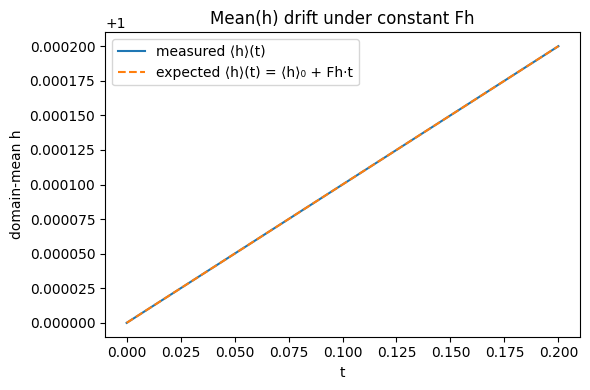

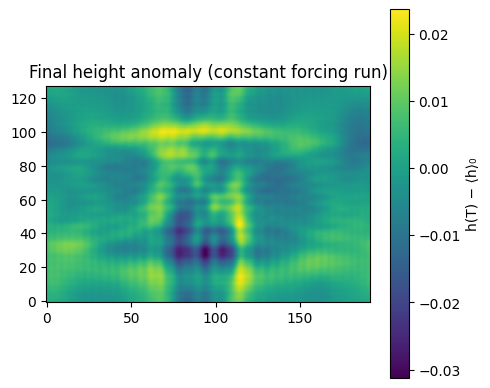

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Mean(h) vs time: measured vs expected (constant Fh run)
ts = np.array(sol_forced.t, dtype=float)
mean_h_t = np.array([float(np.mean(Y[0])) for Y in sol_forced.y], dtype=float)

expected_line = mh0 + Fh_const * ts  # for the constant forcing case

plt.figure(figsize=(6,4))
plt.plot(ts, mean_h_t, label="measured ⟨h⟩(t)")
plt.plot(ts, expected_line, ls="--", label="expected ⟨h⟩(t) = ⟨h⟩₀ + Fh·t")
plt.xlabel("t")
plt.ylabel("domain-mean h")
plt.title("Mean(h) drift under constant Fh")
plt.legend()
plt.tight_layout()
plt.savefig((out_dir / "real_nc_forced" / "mean_h_drift.png"), dpi=150)
plt.show()

# 2) Final height anomaly from initial mean (for a quick sanity snapshot)
hT = sol_forced.y[-1][0]
anomT = hT - mh0

plt.figure(figsize=(5,4))
im = plt.imshow(anomT, origin="lower")
plt.colorbar(im, label="h(T) − ⟨h⟩₀")
plt.title("Final height anomaly (constant forcing run)")
plt.tight_layout()
plt.savefig((out_dir / "real_nc_forced" / "h_anomaly_final.png"), dpi=150)
plt.show()